In [16]:
# import the necessary libraries

from watermark import watermark
import sys
import os
import platform
from os.path import exists

import yfinance as yf
import pandas as pd
import numpy as np
import talib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import talib

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Report Technologies
print(f'Python Platform: {platform.platform()}')
print(f'Python {sys.version}')
print(watermark())
print(watermark(iversions=True, globals_=globals()))


Python Platform: macOS-13.0.1-arm64-arm-64bit
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
Last updated: 2023-04-28T18:46:39.886177-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

platform  : 1.0.8
pandas    : 1.5.1
yfinance  : 0.2.18
talib     : 0.4.26
sys       : 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) 
[Clang 14.0.6 ]
numpy     : 1.24.3
matplotlib: 3.5.3



In [3]:
# Load data from Yahoo Finance
asset = yf.Ticker("AAPL")
data = asset.history(period="max")

In [4]:
# Create a feature set consisting of the closing prices for the past 10 days
look_back = 10
data['MA'] = data['Close'].rolling(window=look_back).mean()
data = data.dropna()
X = data[['MA']].values
y = data['Close'].values

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [6]:
# Train a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression()

In [7]:
# Predict the closing price for the next day using the trained model
last_n = data.tail(n=look_back)
next_day_MA = last_n['Close'].mean()
next_day_pred = model.predict([[next_day_MA]])

print("Next day predicted price: $", next_day_pred[0])


Next day predicted price: $ 166.67112132442975


[*********************100%***********************]  1 of 1 completed


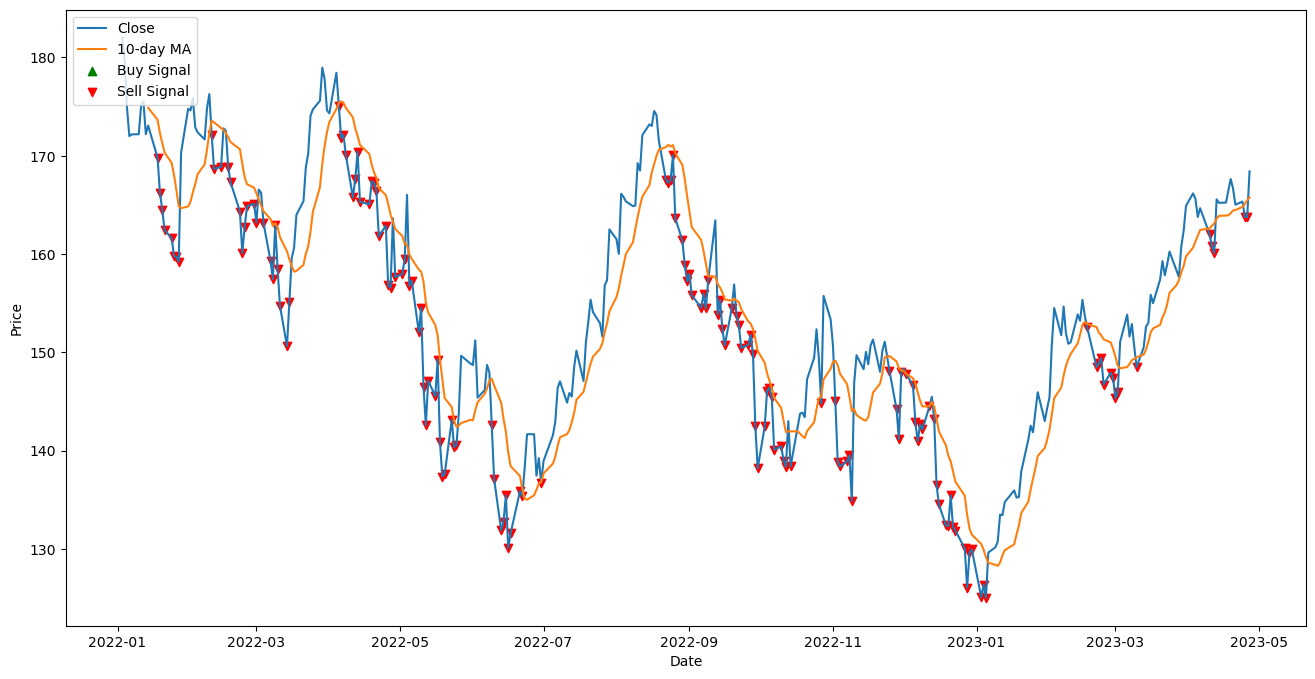

In [8]:
# Download data from Yahoo Finance
data = yf.download("AAPL", start="2022-01-01", end="2023-04-28")

# Define the window size for the moving average
window_size = 10

# Create a new column with the moving average
data['MA'] = data['Close'].rolling(window_size).mean()

# Create a new column for the buy and sell signals
data['Signal'] = 0

# Fit a linear regression model to the data
X = np.array(data.index.factorize())[0].reshape(-1, 1)
y = data['Close'].values.reshape(-1, 1)
model = LinearRegression().fit(X, y)

# Generate predictions for the entire data set
y_pred = model.predict(X)

# Iterate over the data set and generate buy and sell signals
for i in range(window_size, len(data)):
    if data['Close'][i] > data['MA'][i] and y_pred[i] > y_pred[i-1]:
        data['Signal'][i] = 1
    elif data['Close'][i] < data['MA'][i] and y_pred[i] < y_pred[i-1]:
        data['Signal'][i] = -1

# Plot the results
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(data['Close'], label='Close')
ax.plot(data['MA'], label=f'{window_size}-day MA')
ax.scatter(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], marker='^', color='green', label='Buy Signal')
ax.scatter(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], marker='v', color='red', label='Sell Signal')

ax.legend(loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()


[*********************100%***********************]  1 of 1 completed


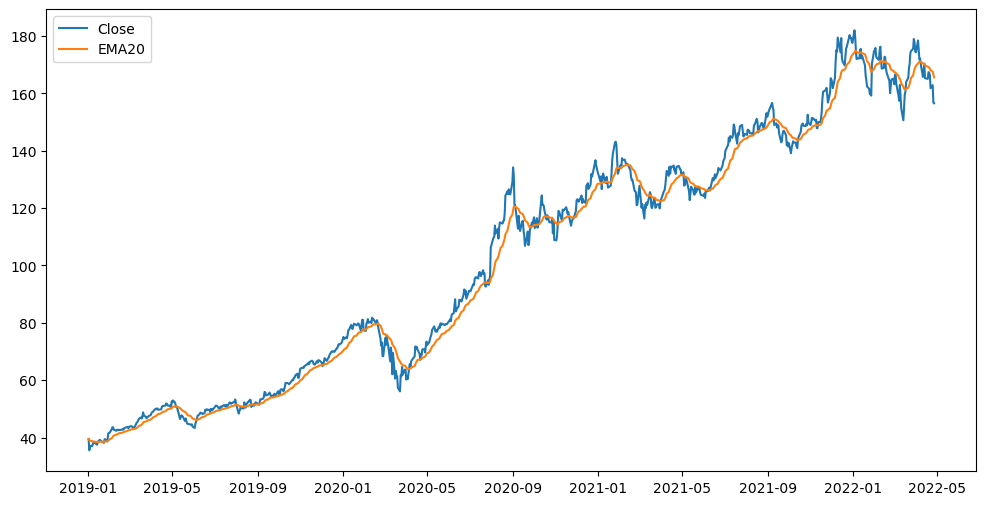

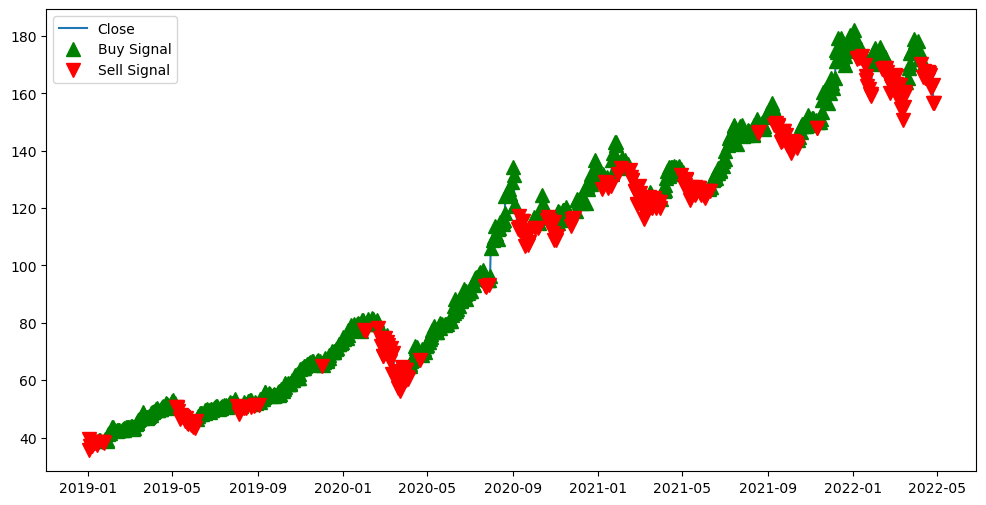

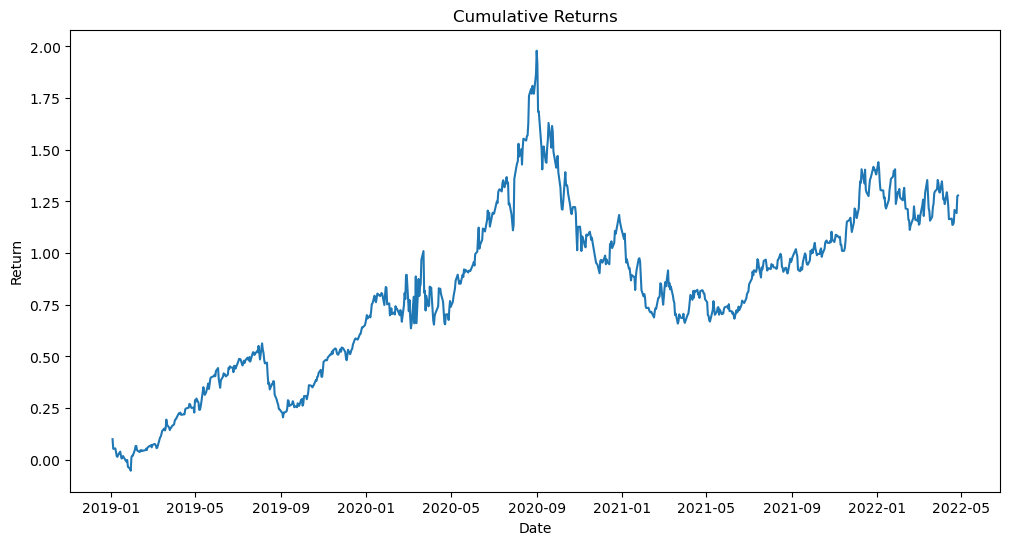

In [9]:

# Load data
data = yf.download('AAPL', start='2019-01-01', end='2022-04-28')

# Calculate exponential moving average
data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

# Define buy and sell signals based on EMA
data['Signal'] = np.where(data['Close'] > data['EMA20'], 1, -1)

# Calculate daily returns
data['Return'] = data['Close'].pct_change()

# Calculate strategy returns
data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']

# Calculate cumulative returns
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod() - 1

# Plot close price and EMA
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['EMA20'], label='EMA20')
plt.legend()

# Plot buy and sell signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close')
plt.plot(data.loc[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data.loc[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], 'v', markersize=10, color='red', label='Sell Signal')
plt.legend()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Return'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()



[*********************100%***********************]  1 of 1 completed


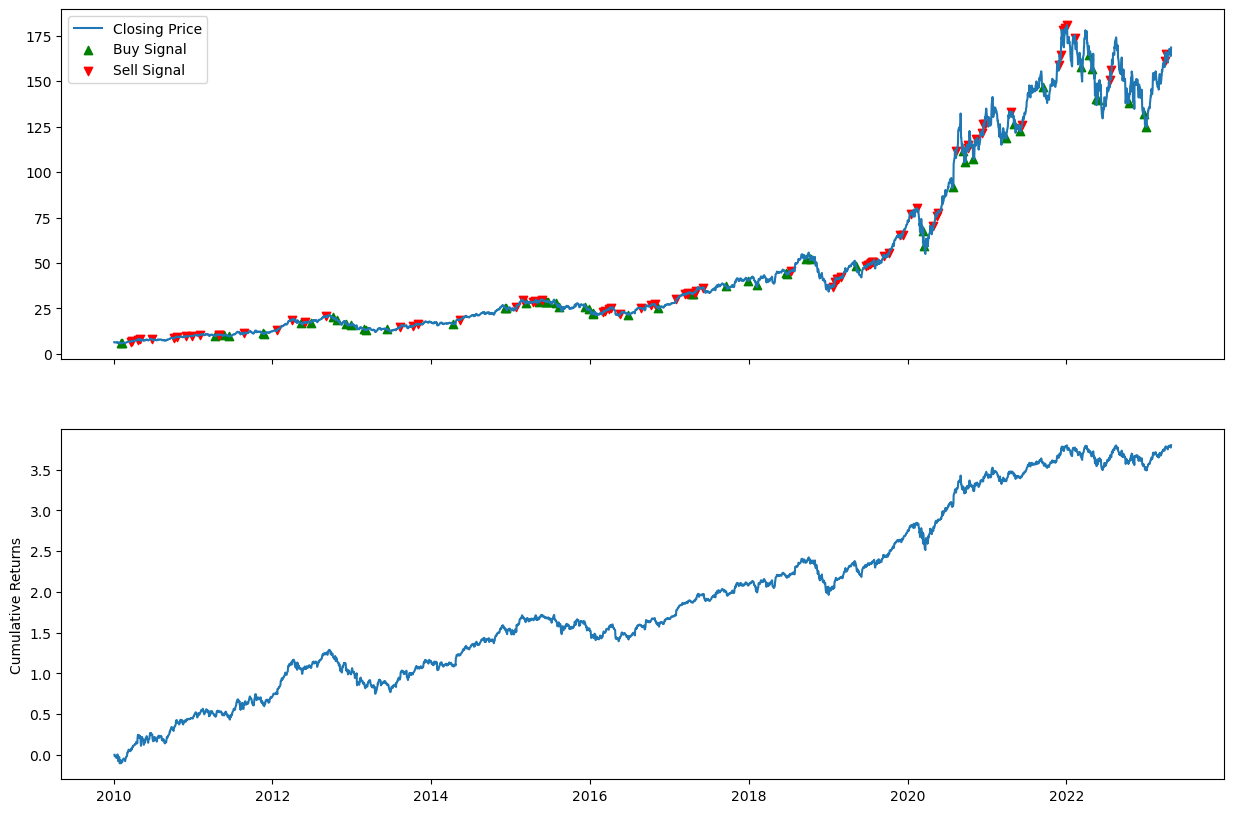

In [10]:
# Define function to calculate stochastic oscillator
def calc_stochastic(high, low, close, k_period=14, d_period=3, smoothing=1):
    # Calculate %K
    k = 100 * ((close - close.rolling(window=k_period).min()) / 
               (close.rolling(window=k_period).max() - close.rolling(window=k_period).min()))
    
    # Apply smoothing to %K
    k_smoothed = k.ewm(span=smoothing, min_periods=0, adjust=False).mean()
    
    # Calculate %D
    d = k_smoothed.rolling(window=d_period).mean()
    
    return k_smoothed, d

# Load data
data = yf.download("AAPL", start="2010-01-01", end="2023-04-28")

# Calculate stochastic oscillator
k, d = calc_stochastic(data['High'], data['Low'], data['Close'])

# Define overbought and oversold levels
overbought = 80
oversold = 20

# Generate buy and sell signals based on overbought and oversold levels
data['Stochastic Buy'] = ((k < oversold) & (k.shift(1) > oversold) & (d < oversold)).astype(int)
data['Stochastic Sell'] = ((k > overbought) & (k.shift(1) < overbought) & (d > overbought)).astype(int)

# Calculate returns
data['Returns'] = data['Adj Close'].pct_change()

# Plot closing price, buy and sell signals, and returns
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot closing price and buy/sell signals
ax[0].plot(data.index, data['Adj Close'], label='Closing Price')
ax[0].scatter(data[data['Stochastic Buy'] == 1].index, 
              data[data['Stochastic Buy'] == 1]['Adj Close'], 
              marker='^', color='green', label='Buy Signal')
ax[0].scatter(data[data['Stochastic Sell'] == 1].index, 
              data[data['Stochastic Sell'] == 1]['Adj Close'], 
              marker='v', color='red', label='Sell Signal')
ax[0].legend()

# Plot returns
ax[1].plot(data.index, data['Returns'].cumsum())
ax[1].set_ylabel('Cumulative Returns')

# Show plot
plt.show()


In [14]:
# Download historical data
stock = yf.Ticker("EURUSD=X")
df = stock.history(period="1y")

# Compute the stochastic oscillator
df['%K'] = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)[0]
df['%D'] = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowd_period=3)[1]

# Define buy/sell signals based on the stochastic oscillator and a logistic regression model
df['Close_shifted'] = df['Close'].shift(1)
df = df.dropna()
X = df[['%K', '%D']].shift(1).dropna()
y = np.where(df['Close'] > df['Close_shifted'], 1, 0)
y = y[1:]  # add this line to remove the first element of y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)

Confusion Matrix:
[[ 6 18]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.25      0.32        24
           1       0.49      0.68      0.57        25

    accuracy                           0.47        49
   macro avg       0.46      0.47      0.44        49
weighted avg       0.46      0.47      0.44        49



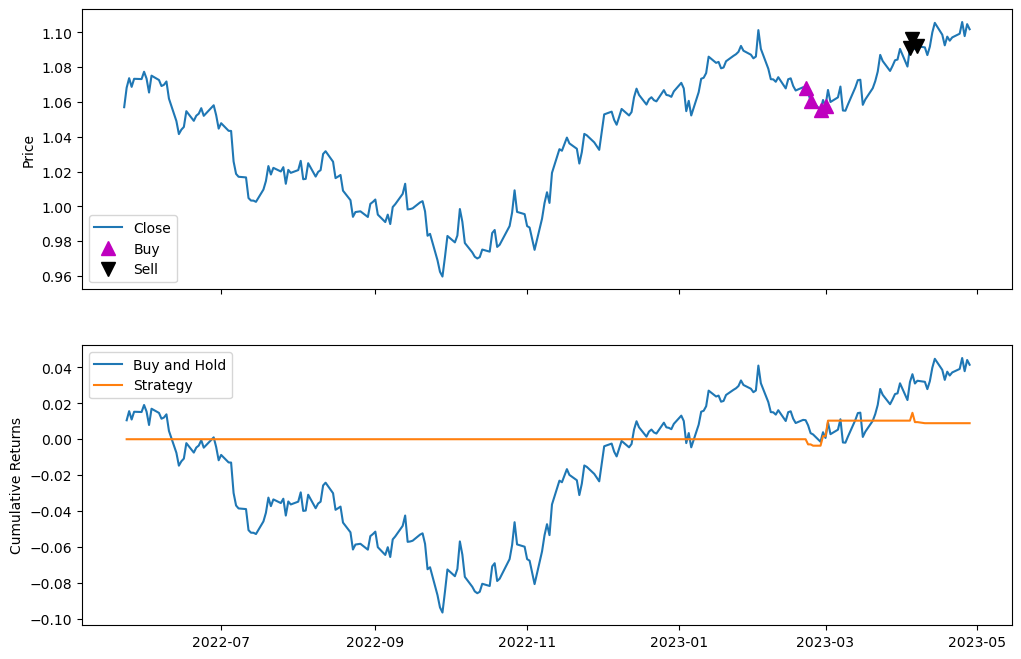

In [15]:

df['Prediction'] = np.nan
df['Prediction'].iloc[-len(y_pred):] = y_pred
df['Buy'] = np.where((df['%K'] < 20) & (df['%D'] < 20) & (df['Prediction'] == 1), 1, 0)
df['Sell'] = np.where((df['%K'] > 80) & (df['%D'] > 80) & (df['Prediction'] == 0), 1, 0)

# Compute returns based on the buy/sell signals
df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df['Cumulative Returns'] = df['Returns'].cumsum()
df['Strategy Returns'] = df['Returns'] * (df['Buy'] + df['Sell']).shift(1)
df['Cumulative Strategy Returns'] = df['Strategy Returns'].cumsum()

# Visualize the results
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)

ax[0].plot(df['Close'])
ax[0].plot(df[df['Buy'] == 1].index, df['Close'][df['Buy'] == 1], '^', markersize=10, color='m')
ax[0].plot(df[df['Sell'] == 1].index, df['Close'][df['Sell'] == 1], 'v', markersize=10, color='k')
ax[0].legend(['Close', 'Buy', 'Sell'])
ax[0].set_ylabel('Price')

ax[1].plot(df['Cumulative Returns'])
ax[1].plot(df['Cumulative Strategy Returns'])
ax[1].legend(['Buy and Hold', 'Strategy'])
ax[1].set_ylabel('Cumulative Returns')

plt.show()
